<a href="https://colab.research.google.com/github/XuanLoc2578/StockGE_Prediction/blob/main/Torch_StockGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem: Predict the Adj Close price of the GE Stock in the near future**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import files
files.upload()
!ls

Saving GE.csv to GE.csv
GE.csv	sample_data


## **Preprocessing**
⬇⬇⬇

In [3]:
df = pd.read_csv("GE.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2/2/2021,87.040001,90.800003,86.720001,89.919998,89.637154,10558238
1,2/3/2021,89.919998,90.400002,88.559998,89.599998,89.318161,6776850
2,2/4/2021,89.839996,92.000000,89.519997,91.599998,91.311874,8345975
3,2/5/2021,92.080002,92.400002,90.559998,91.199997,90.913139,6477300
4,2/8/2021,91.760002,93.199997,91.279999,92.879997,92.587852,5306813


In [4]:
df.isnull().sum().sort_values(ascending=False)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,254.000000,254.000000,254.000000,254.000000,254.000000,2.540000e+02
mean,102.741850,104.068583,101.349291,102.732441,102.563584,8.106468e+06
std,5.473912,5.402131,5.320442,5.251249,5.213438,4.107476e+06
min,87.040001,90.099998,86.720001,89.320000,89.318161,1.968774e+06
25%,100.207498,101.815003,99.119998,100.334999,100.056900,5.851154e+06
50%,103.754998,105.184998,102.535000,103.819999,103.603649,7.341782e+06
75%,106.000000,107.070002,104.639999,106.030001,105.874201,8.683725e+06
max,114.730003,116.169998,112.800003,114.800003,114.523300,3.822566e+07


In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-02,87.040001,90.800003,86.720001,89.919998,89.637154,10558238
1,2021-02-03,89.919998,90.400002,88.559998,89.599998,89.318161,6776850
2,2021-02-04,89.839996,92.000000,89.519997,91.599998,91.311874,8345975
3,2021-02-05,92.080002,92.400002,90.559998,91.199997,90.913139,6477300
4,2021-02-08,91.760002,93.199997,91.279999,92.879997,92.587852,5306813


In [7]:
df = df.set_index("Date") 

In [8]:
t_s = pd.Series(df.index)

In [9]:
df.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [10]:
df = df.drop("Volume", axis=1)
obj_list = df.keys()

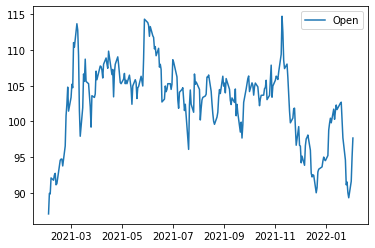

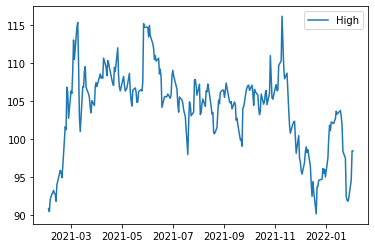

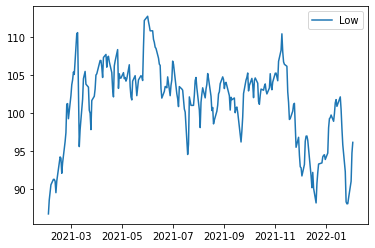

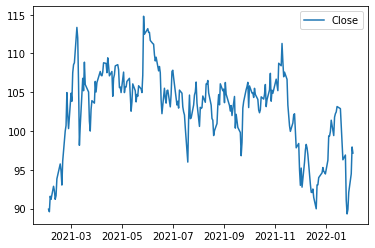

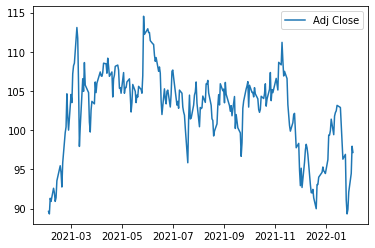

In [11]:
for obj in obj_list:
  plt.plot(df.index, df[obj], label=obj)
  plt.legend()
  plt.show()

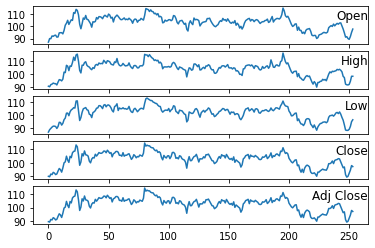

In [12]:
data = df.values
groups = [0, 1, 2, 3, 4]
i = 1

plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(data[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [13]:
data.shape

(254, 5)

In [14]:
sc = MinMaxScaler(feature_range=(0, 1))
data = sc.fit_transform(data)

## **Create model**
⬇⬇⬇

In [15]:
def window(data, seq_length):
  x = []
  y = []

  for i in range(data.shape[0]-seq_length-1):
    tmp_x = data[i:(i+seq_length), :]
    tmp_y = data[i+seq_length, :]
    x.append(tmp_x)
    y.append(tmp_y)

  return np.array(x), np.array(y)

In [16]:
seq_length = 6

x, y = window(data, seq_length)
x.shape, y.shape

((247, 6, 5), (247, 5))

In [17]:
test_size = int(y.shape[0]*0.2)

X_train, y_train = x[:-test_size, :], y[:-test_size, :]
X_test, y_test = x[-test_size:, :], y[-test_size:, :]

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((198, 6, 5), (198, 5), (49, 6, 5), (49, 5))

In [19]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [20]:
class LSTM(nn.Module):
  def __init__(self, inp_size, hid_size, seq_len, n_layer):
    super().__init__()
    self.inp_size = inp_size
    self.hid_size = hid_size
    self.seq_len = seq_len
    self.n_layer = n_layer

    self.lstm = nn.LSTM(inp_size, hid_size, n_layer)
    self.linear = nn.Linear(hid_size*seq_len, 5)

  def forward(self, x):
    h0 = torch.zeros(self.n_layer, self.seq_len, self.hid_size)
    c0 = torch.zeros(self.n_layer, self.seq_len, self.hid_size)
    
    out, _ = self.lstm(x, (h0, c0))
    out = out.reshape(out.shape[0], -1)
    return self.linear(out)

In [21]:
inp_size = X_train.shape[2]
hid_size = 1
seq_len = seq_length
n_layer = 1
lr = 0.01
num_epoch = 1500

model = LSTM(inp_size, hid_size, seq_len, n_layer)

In [22]:
loss = nn.MSELoss()
solver = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(solver, patience=10, factor=0.5, verbose=True)

Epoch 0, loss 0.1901756227016449
Epoch 150, loss 0.012193731032311916
Epoch 300, loss 0.0069695585407316685
Epoch 450, loss 0.004674481227993965
Epoch 600, loss 0.004450884182006121
Epoch 750, loss 0.004387884400784969
Epoch 900, loss 0.004360819235444069
Epoch 1050, loss 0.004342211876064539
Epoch 1200, loss 0.004326419904828072
Epoch 1350, loss 0.0043122423812747


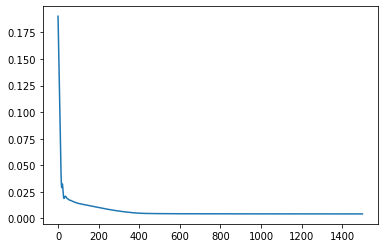

In [23]:
loss_list = []

for epoch in range(num_epoch):
  l = loss(model(X_train), y_train)
  solver.zero_grad()
  l.backward()
  loss_list.append(l)
  solver.step()
  # scheduler.step(l)

  if epoch%(num_epoch/10)==0:
    print(f"Epoch {epoch}, loss {l}")


plt.plot(loss_list)

In [24]:
x_torch = torch.tensor(x, dtype=torch.float32)
data_pred = model(x_torch)

In [25]:
model.eval()

x_torch = torch.tensor(x_torch, dtype=torch.float32).reshape(-1, 5)
y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 5)

data_pred = data_pred.data.numpy()
data_y = y_torch.data.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


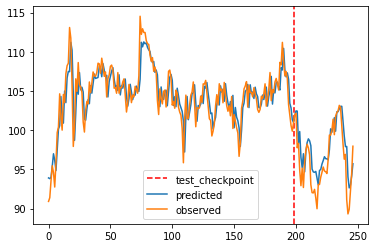

In [26]:
data_pred_inv = sc.inverse_transform(data_pred)
data_y_inv = sc.inverse_transform(data_y)

plt.axvline(x=len(x)-test_size, c="r", linestyle="--", label="test_checkpoint")

plt.plot(data_pred_inv[:, -1], label="predicted")
plt.plot(data_y_inv[:, -1], label="observed")
plt.legend()
plt.show()

In [27]:
print(f"RMSE {math.sqrt(mean_squared_error(data_y_inv[-1], data_pred_inv[-1]))}")

RMSE 1.6436138720404405


## **Future Prediction**
⬇⬇⬇

In [28]:
type(df), type(x), type(y), type(X_train),type(y_train), type(X_test), type(y_test)

(pandas.core.frame.DataFrame,
 numpy.ndarray,
 numpy.ndarray,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor)

In [29]:
df.shape, x.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((254, 5),
 (247, 6, 5),
 (247, 5),
 torch.Size([198, 6, 5]),
 torch.Size([198, 5]),
 torch.Size([49, 6, 5]),
 torch.Size([49, 5]))

In [51]:
days_to_pred = 10
future_index = pd.date_range(start=t_s[len(t_s)-1], periods=days_to_pred)

In [52]:
x_t = torch.tensor(x, dtype=torch.float32)

In [53]:
with torch.no_grad():
  seq = x_t[-1]
  seq = seq[None, :]
  preds = np.array([])

  for _ in range(days_to_pred):
    y_fu_pred = model(seq)
    pred = torch.flatten(y_fu_pred)
    preds = np.append(preds, pred)
    new_seq = seq.numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[5:]
    seq = torch.tensor(new_seq).reshape(1, -1, 5)

In [54]:
preds = preds.reshape(-1, 5)
preds_inv = sc.inverse_transform(preds)

In [55]:
predicted_case = pd.Series(data=preds_inv[:, 4], index=future_index, name="Future Adj Close")

In [56]:
predicted_case.index = pd.to_datetime(predicted_case.index)
predicted_case_df = pd.DataFrame(predicted_case)
predicted_case_df = predicted_case_df.set_index(predicted_case_df.index)

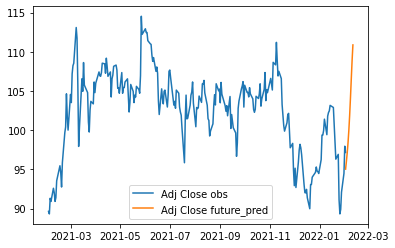

In [57]:
plt.plot(df.index, df["Adj Close"][:], label="Adj Close obs")
plt.plot(predicted_case_df.index, predicted_case_df["Future Adj Close"][:], label="Adj Close future_pred")
plt.legend()
plt.show()